# Iris dataset Clustering

### Aidin Hosseini - 98103115
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import iris dataset
from sklearn.datasets import load_iris
import seaborn as sns
# import train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
%matplotlib widget

## Importing Iris dataset
Cell below uses **datasets** from **sklearn** to get the iris dataset.

In [3]:
# importing iris dataset from sklearn
iris_dataset,iris_class = load_iris(return_X_y=True)

standardScaler is used to normalize the data.

In [4]:
#normalize the data using StandardScaler
scaler = StandardScaler()
train_set = scaler.fit_transform(iris_dataset)

[0.72962445 0.95813207 0.99482129 1.        ]


Text(0, 0.5, 'Cumulative explained variance')

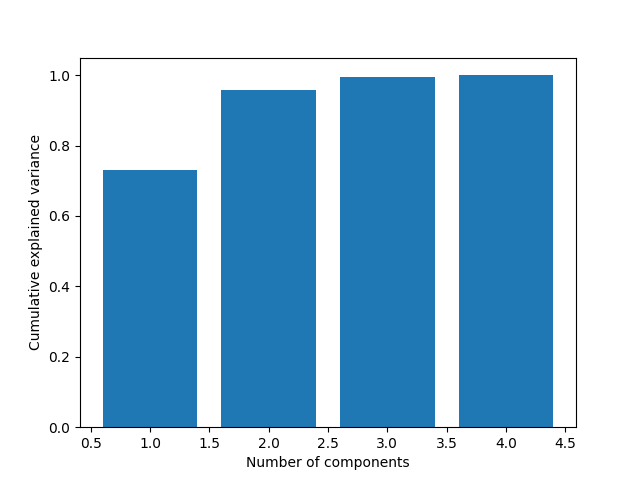

In [5]:
#normalize the data using StandardScaler
pca = PCA()
pca.fit(train_set)
print(np.cumsum(pca.explained_variance_ratio_))
plt.bar(range(1,5),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

As it is shown above the fourth feature is the least important feature in the dataset. So we drop it from the dataset.

In [6]:
pca = PCA(n_components=3)
train_set = pca.fit_transform(train_set)

### visualization

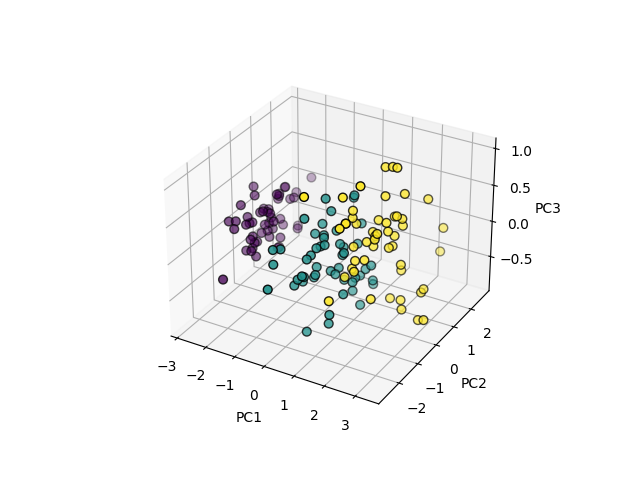

In [7]:
# visulizing the data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_set[:,0],train_set[:,1],train_set[:,2],c=iris_class,cmap='viridis',edgecolor='k', s=40)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()



### dunn index

In [8]:
def dunns_index(data,labels):
    max_diam = -1
    min_diff = 100000000
    for i in range(len(labels)):
        for j in range(len(labels)):
            if (labels[i]==labels[j]):
                diam = np.linalg.norm(data[i]-data[j])
                max_diam = max(max_diam,diam)
            else:
                diff = np.linalg.norm(data[i]-data[j])
                min_diff = min(min_diff,diff)
    return min_diff/max_diam

### Implementing K-Means algorithm

In [9]:
# Implement KMeans algorithm from scratch
class KMeans:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.centroids = None
        self.labels = None

    def distance(self, x1, x2):
        return np.sqrt(((x1 - x2)**2).sum(axis=1))
    
        
    
    def fit(self, data):
        # randomly select centroids
        self.centroids = data[np.random.choice(data.shape[0], self.n_clusters, replace=False)]
        prev = np.zeros(data.shape[0])
        # if the labels are not changing or max_iter is reached, stop
        while (not np.all(prev == self.labels)):
            prev = self.labels
            # calculate distance between each data point and centroids
            distance = np.array([self.distance(data, centroid) for centroid in self.centroids])
            # assign each data point to its nearest centroid
            self.labels = np.argmin(distance, axis=0)
            # update centroids
            self.centroids = np.array([data[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return self.labels



In [10]:
# 3 clusters
kmeans3 = KMeans(n_clusters=3)
labels3 = kmeans3.fit(train_set)
print('davies bouldin score: '+str(davies_bouldin_score(train_set,labels3)))
print('dunns index: '+str(dunns_index(train_set,labels3)))


davies bouldin score: 0.8490187650873047
dunns index: 0.04688459772002924


In [11]:
# 2 clusters
kmeans2 = KMeans(n_clusters=2)
labels2 = kmeans2.fit(train_set)
print('davies bouldin score: '+str(davies_bouldin_score(train_set,labels2)))
print('dunns index: '+str(dunns_index(train_set,labels2)))

davies bouldin score: 0.5861274075411329
dunns index: 0.26154428504797533


In [12]:
# 4 clusters
kmeans4 = KMeans(n_clusters=4)
labels4 = kmeans4.fit(train_set)
print('davies bouldin score: '+str(davies_bouldin_score(train_set,labels4)))
print('dunns index: '+str(dunns_index(train_set,labels4)))


davies bouldin score: 0.9025896952563431
dunns index: 0.03574354157617034


In [13]:
# 5 clusters
kmeans5 = KMeans(n_clusters=5)
labels5 = kmeans5.fit(train_set)
print('davies bouldin score: '+str(davies_bouldin_score(train_set,labels5)))
print('dunns index: '+str(dunns_index(train_set,labels5)))


davies bouldin score: 0.8941736324947002
dunns index: 0.03520426871511134


dunn index should be maximized and davies bouldin score should be minimized. So dunn index and davies bouldin score both suggest that the best number of clusters is 2.<br>
the next minimum value of davies bouldin score & maximum dunn index is for 3 clusters. If it wasn't obvious that Iris dataset has 3 clusters, Choosing 2 cluster would be the best choice.

### Partion Coefficient
if the value of partion coefficient is close to 1, it means that the clusters are well separated from each other.

In [14]:
def PC(u,n):
    return np.sum(u**2)/n

### Xie-Beni Index
if this index is minimized, it means that the clusters are compact and well separated.

In [15]:
def Xie_Beni(data,u,centroids,q=2):
    n = data.shape[0]
    k = centroids.shape[0]
    PCj = np.zeros(k)
    min_centroid = 1000000
    for i in range(k):
        for j in range(k):
            if (i!=j):
                dist = np.linalg.norm(centroids[i]-centroids[j])
                min_centroid = min(min_centroid,dist)
    summ = 0
    for i in range(n):
        for j in range(k):
           summ+=(np.linalg.norm(data[i]-centroids[j])**2)*(u[i][j]**q)
        
    return summ/(n*min_centroid**2)

### Fuzzy C-Means

In [16]:
class FuzzyCMeans:
    def __init__(self, n_clusters=3,q=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.u = None
        self.labels = None
        self.q = q

    def distance(self, x1, x2):
        return np.linalg.norm(x1-x2)
    
    def fit(self, data):
        self.centroids = data[np.random.choice(data.shape[0], self.n_clusters, replace=False)]
        self.centroids -= 0.000001
        self.u = np.zeros((data.shape[0],self.n_clusters))
        for repeat in range(self.max_iter):
            for i in range(data.shape[0]):
                for j in range (self.n_clusters):
                    summ = 0
                    for k in range(self.n_clusters):
                        summ += (self.distance(data[i],self.centroids[j])/self.distance(data[i],self.centroids[k]))**(1/(self.q-1))
                    self.u[i][j] = 1/summ
            for j in range(self.n_clusters):
                summ = 0 
                for i in range(data.shape[0]):
                    self.centroids[j] += self.u[i][j]**self.q*data[i]
                    summ += self.u[i][j]**self.q
                self.centroids[j] /= summ
        
        return self.u

In [17]:
fuuzy3_q2 = FuzzyCMeans(n_clusters=3,q=2)
u3_q2 = fuuzy3_q2.fit(train_set)
print('number of clusters: 3, q=2')
print('partition coefficient: '+str(PC(u3_q2,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u3_q2,fuuzy3_q2.centroids,2)))

number of clusters: 3, q=2
partition coefficient: 0.46613142340491653
Xie Beni index: 1.2754254049999998


In [18]:
fuuzy3_q3 = FuzzyCMeans(n_clusters=3,q=3)
u3_q3 = fuuzy3_q3.fit(train_set)
print('number of clusters: 3, q=3')
print('partition coefficient: '+str(PC(u3_q3,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u3_q3,fuuzy3_q3.centroids,3)))

number of clusters: 3, q=3
partition coefficient: 0.36650204818334753
Xie Beni index: 344736.50869642646


C:\Users\aidin\AppData\Local\Temp\ipykernel_17004\371808618.py:22: RuntimeWarning: overflow encountered in double_scalars
  summ += (self.distance(data[i],self.centroids[j])/self.distance(data[i],self.centroids[k]))**(1/(self.q-1))


number of clusters: 3, q=1.1
partition coefficient: 0.9994268162030202
Xie Beni index: 0.2644847245034014


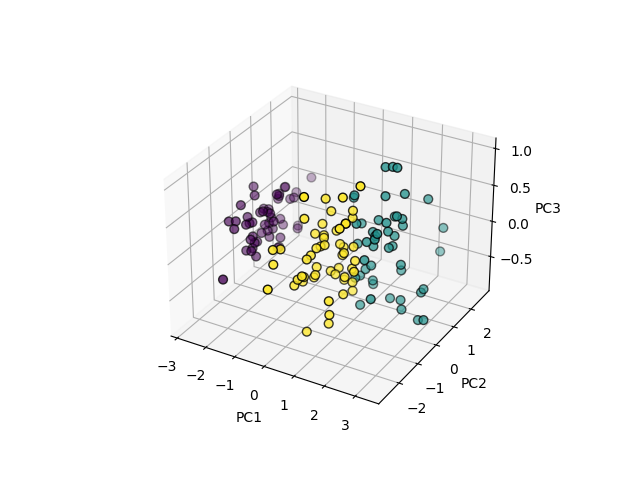

In [26]:
fuzzy3_q1_01 = FuzzyCMeans(n_clusters=3,q=1.01)
u3_q1_01 = fuzzy3_q1_01.fit(train_set)
print('number of clusters: 3, q=1.1')
print('partition coefficient: '+str(PC(u3_q1_01,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u3_q1_01,fuzzy3_q1_01.centroids,1.01)))
labels3_q1_01 = np.argmax(u3_q1_01,axis=1)
# visulizing the data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_set[:,0],train_set[:,1],train_set[:,2],c=labels3_q1_01,cmap='viridis',edgecolor='k', s=40)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [20]:
fuzzy2_q2 = FuzzyCMeans(n_clusters=2,q=2)
u2_q2 = fuzzy2_q2.fit(train_set)
print('number of clusters: 2, q=2')
print('partition coefficient: '+str(PC(u2_q2,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u2_q2,fuzzy2_q2.centroids,2)))


number of clusters: 2, q=2
partition coefficient: 0.6267166527851845
Xie Beni index: 0.22358803018822723


In [21]:
fuzzy2_q3 = FuzzyCMeans(n_clusters=2,q=3)
u2_q3 = fuzzy2_q3.fit(train_set)
print('number of clusters: 2, q=3')
print('partition coefficient: '+str(PC(u2_q3,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u2_q3,fuzzy2_q3.centroids,3)))


number of clusters: 2, q=3
partition coefficient: 0.5139244906475736
Xie Beni index: 0.5683646836936297


In [22]:
fuzzzy2_q1_5 = FuzzyCMeans(n_clusters=2,q=1.5)
u2_q1_5 = fuzzzy2_q1_5.fit(train_set)
print('number of clusters: 2, q=1.5')
print('partition coefficient: '+str(PC(u2_q1_5,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u2_q1_5,fuzzzy2_q1_5.centroids,1.5)))


number of clusters: 2, q=1.5
partition coefficient: 0.8270038151968773
Xie Beni index: 0.16264433907104137


In [23]:
fuzzy2_q1_1 = FuzzyCMeans(n_clusters=2,q=1.1)
u2_q1_1 = fuzzy2_q1_1.fit(train_set)
print('number of clusters: 2, q=1.1')
print('partition coefficient: '+str(PC(u2_q1_1,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u2_q1_1,fuzzy2_q1_1.centroids,1.1)))


number of clusters: 2, q=1.1
partition coefficient: 0.9935142246649423
Xie Beni index: 0.12594149719662084


C:\Users\aidin\AppData\Local\Temp\ipykernel_17004\371808618.py:22: RuntimeWarning: overflow encountered in double_scalars
  summ += (self.distance(data[i],self.centroids[j])/self.distance(data[i],self.centroids[k]))**(1/(self.q-1))


number of clusters: 2, q=1.01
partition coefficient: 0.9999999996214137
Xie Beni index: 0.1248399473877232


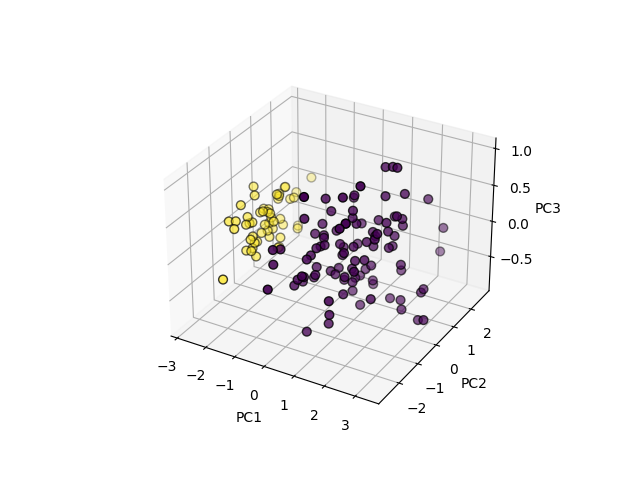

In [24]:
fuzzy2_q1_01 = FuzzyCMeans(n_clusters=2,q=1.01)
u2_q1_01 = fuzzy2_q1_01.fit(train_set)
print('number of clusters: 2, q=1.01')
print('partition coefficient: '+str(PC(u2_q1_01,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u2_q1_01,fuzzy2_q1_01.centroids,1.01)))
labels2_q1_01 = np.argmax(u2_q1_01,axis=1)
# visulizing the data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_set[:,0],train_set[:,1],train_set[:,2],c=labels2_q1_01,cmap='viridis',edgecolor='k', s=40)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [25]:
fuzy4_q2 = FuzzyCMeans(n_clusters=4,q=2)
u4_q2 = fuzy4_q2.fit(train_set)
print('number of clusters: 4, q=2')
print('partition coefficient: '+str(PC(u4_q2,train_set.shape[0])))
print('Xie Beni index: '+str(Xie_Beni(train_set,u4_q2,fuzy4_q2.centroids,2)))

number of clusters: 4, q=2
partition coefficient: 0.37399955837187465
Xie Beni index: 1.6043546999808775


As it is shown above if q is near 1 the partition coefficient is near 1 and Xie-Beni Index is near 0. So the clustering is better. Also if number of clusters is 2 the partition coefficient is near 1 and Xie-Beni Index is near 0. So the clustering is better. Although we know that the real number of clusters is 3. So we have to choose q near 1 to get the best result.

both clustering methods have the same results. they suggest that the best number of clusters is 2. since both of the methods are sensible to the outliers and Iris dataset doesn't have too many outliers, the results are acceptable. k-Means algorithm is sensitive to initial centroids and fuzzy c-means is sensitive to q. So we have to choose them carefully. However it is easy to choose the best q for fuzzy c-means algorithm. But it is not easy to choose the best initial centroids for k-Means algorithm.